In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sales = pd.read_csv("data/bookstore_sales.csv")

In [3]:
sales.head()

,date,year,month,store_id,channel,transactions,revenue,gst_collected,net_revenue,dataset
0,2019-01-01,2019,1,YYC-DT,IN_STORE,64,1985.46,99.27,1886.19,bookstore_sales
1,2019-01-01,2019,1,YYC-DT,ONLINE,8,207.72,10.39,197.33,bookstore_sales
2,2019-01-01,2019,1,YYC-NW,IN_STORE,49,1466.95,73.35,1393.60,bookstore_sales
3,2019-01-01,2019,1,YYC-NW,ONLINE,4,148.89,7.44,141.45,bookstore_sales
4,2019-01-01,2019,1,YYC-SE,IN_STORE,33,1272.70,63.64,1209.06,bookstore_sales


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13152 entries, 0 to 13151
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           13152 non-null  object 
 1   year           13152 non-null  int64  
 2   month          13152 non-null  int64  
 3   store_id       13152 non-null  object 
 4   channel        13152 non-null  object 
 5   transactions   13152 non-null  int64  
 6   revenue        13152 non-null  float64
 7   gst_collected  13152 non-null  float64
 8   net_revenue    13152 non-null  float64
 9   dataset        13152 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 1.0+ MB


In [5]:
sales["date"] = pd.to_datetime(sales["date"])
sales = sales.sort_values("date")
sales = sales[sales["date"] >= "2020-01-01"]
sales = sales.sort_values("date").set_index("date")

In [6]:
sales.head()

,year,month,store_id,channel,transactions,revenue,gst_collected,net_revenue,dataset
date,,,,,,,,,
2020-01-01,2020,1,YYC-DT,IN_STORE,26,895.77,44.79,850.98,bookstore_sales
2020-01-01,2020,1,YYC-DT,ONLINE,13,497.38,24.87,472.51,bookstore_sales
2020-01-01,2020,1,YYC-NW,IN_STORE,23,729.69,36.48,693.21,bookstore_sales
2020-01-01,2020,1,YYC-NW,ONLINE,12,379.18,18.96,360.22,bookstore_sales
2020-01-01,2020,1,YYC-SE,IN_STORE,17,533.26,26.66,506.60,bookstore_sales


In [7]:
ts = sales["net_revenue"].resample("W").sum()

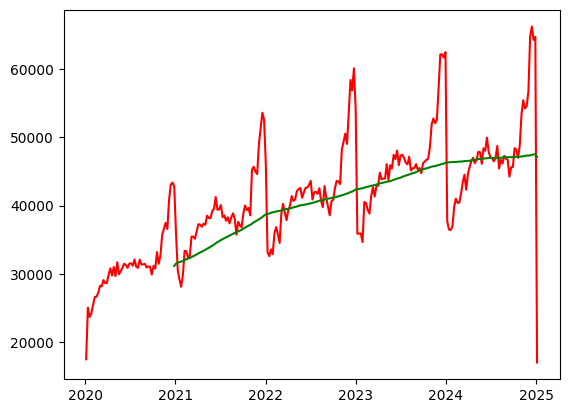

In [8]:
plt.plot(ts, '-r')
plt.plot(ts.rolling(window=52).mean(), '-g');

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss
result = adfuller(ts.values)
result[1]    

np.float64(0.1137601831894634)

In [10]:
ts = sales["net_revenue"].resample("ME").sum()

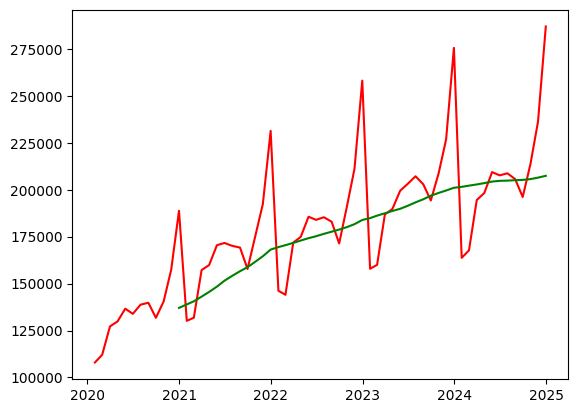

In [11]:
plt.plot(ts, '-r')
plt.plot(ts.rolling(window=12).mean(), '-g');

In [12]:
result = adfuller(ts.values)
result[1] 

np.float64(4.30754871126715e-10)

NO es estacionaria, mucho menos rudio en el mensual

In [13]:
ts_log = np.log(ts)

Estabiliza la varianza y suaviza picos. SARIMA funciona mejor

In [14]:
ts_log.head()

date
2020-01-31    11.589718
2020-02-29    11.626829
2020-03-31    11.753248
2020-04-30    11.773974
2020-05-31    11.824985
Freq: ME, Name: net_revenue, dtype: float64

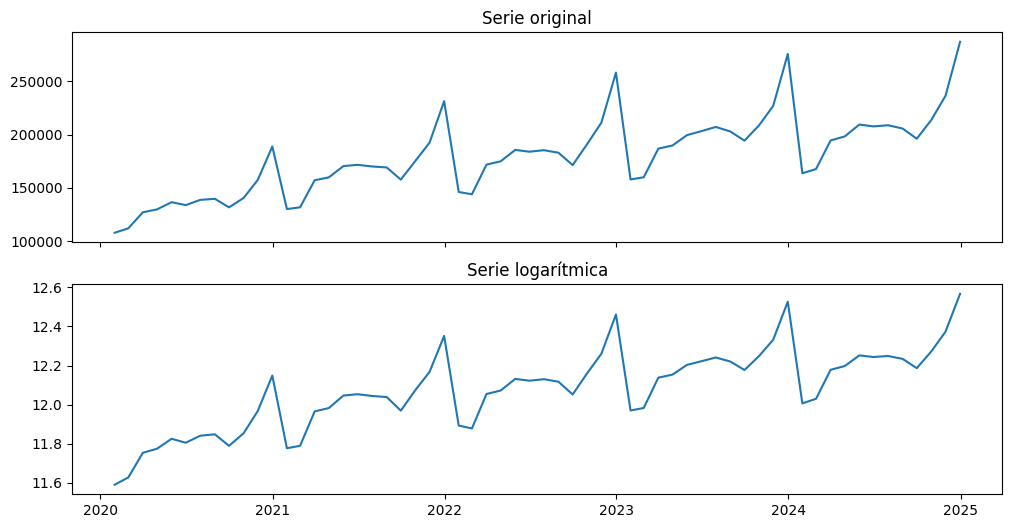

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)

ax[0].plot(ts)
ax[0].set_title("Serie original")

ax[1].plot(ts_log)
ax[1].set_title("Serie logarítmica")

plt.show()


In [16]:
adfuller(ts_log)[1]

np.float64(1.7632570453303367e-16)

In [17]:
train = ts_log.iloc[:-12]
test = ts_log.iloc[-12:]

In [18]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA
from sklearn.metrics import mean_squared_error

In [19]:
auto_model = auto_arima(
    train,
    seasonal=True,
    m=12,
    d=0,
    D=1,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    start_P=0,
    start_Q=0,
    max_P=2,
    max_Q=2,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-101.129, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-153.486, Time=0.80 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-37.680, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-155.391, Time=0.05 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-153.693, Time=0.38 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-152.462, Time=0.75 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=-153.740, Time=0.10 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-153.579, Time=0.25 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-124.336, Time=0.14 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=-151.453, Time=0.27 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=-154.125, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 3.530 seconds
                                     SARIMAX Results                             

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train,
    order=(1,0,0),
    seasonal_order=(0,1,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        net_revenue   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                  79.169
Date:                            Thu, 15 Jan 2026   AIC                           -154.339
Time:                                    18:45:03   BIC                           -151.228
Sample:                                01-31-2020   HQIC                          -153.265
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9613      0.026     37.338      0.000       0.911       1.012
sigma2         0.0006      0.000   

c:\Users\Asier\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
forecast_log = results.get_forecast(steps=len(test)).predicted_mean

In [22]:
import numpy as np

forecast = np.exp(forecast_log)
test_real = np.exp(test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(test_real, forecast))
mae = mean_absolute_error(test_real, forecast)

rmse, mae

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(test_real, forecast))
mae = mean_absolute_error(test_real, forecast)

rmse, mae

(np.float64(4879.169370893489), 4002.304790094204)

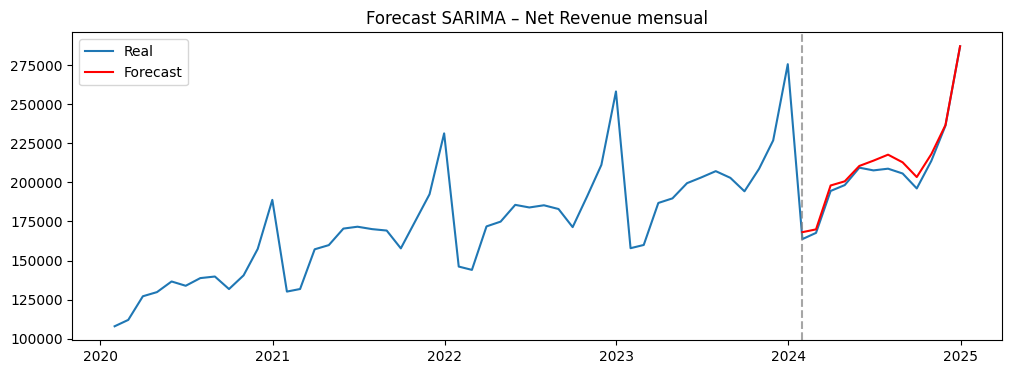

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(np.exp(ts_log), label="Real")
plt.plot(test_real.index, forecast, label="Forecast", color="red")
plt.axvline(test_real.index[0], color="gray", linestyle="--", alpha=0.7)
plt.legend()
plt.title("Forecast SARIMA – Net Revenue mensual")
plt.show()

In [25]:
future_log = results.get_forecast(steps=12).predicted_mean
future = np.exp(future_log)
future

2024-01-31    168145.700721
2024-02-29    169927.156993
2024-03-31    197987.241559
2024-04-30    200640.766296
2024-05-31    210473.773038
2024-06-30    213865.795608
2024-07-31    217681.934546
2024-08-31    212778.921601
2024-09-30    203379.680494
2024-10-31    218048.726321
2024-11-30    236626.273563
2024-12-31    286973.716740
Freq: ME, Name: predicted_mean, dtype: float64